# Classification: comparison between different machine learning algorithms using Otto group product dataset

The Otto Group is one of the world’s biggest e-commerce companies. The Otto group product is a famous dataset containing 93 features of more than 200,000 products. Each feature represent counts of different events. There are nine categories for all products, each of them representing one of the most important product categories (like fashion, electronics, etc.). The goal is to build a model able to predict in which category a given product belongs to.

In this notebook I will apply different machine learning algorithms on this dataset, comparing their performances.

#### The following algorithms will be tested:
* Logistic regression
* k-nearest neighbors
* Random forest
* Gradient boosted decision trees using XGBoost
* Dimensionality reduction: Principal component analysis and TSNE
* Stacking: combination of different algorithms

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory data analysis

In [2]:
df_train = pd.read_csv('train.csv')

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 95 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       61878 non-null  int64 
 1   feat_1   61878 non-null  int64 
 2   feat_2   61878 non-null  int64 
 3   feat_3   61878 non-null  int64 
 4   feat_4   61878 non-null  int64 
 5   feat_5   61878 non-null  int64 
 6   feat_6   61878 non-null  int64 
 7   feat_7   61878 non-null  int64 
 8   feat_8   61878 non-null  int64 
 9   feat_9   61878 non-null  int64 
 10  feat_10  61878 non-null  int64 
 11  feat_11  61878 non-null  int64 
 12  feat_12  61878 non-null  int64 
 13  feat_13  61878 non-null  int64 
 14  feat_14  61878 non-null  int64 
 15  feat_15  61878 non-null  int64 
 16  feat_16  61878 non-null  int64 
 17  feat_17  61878 non-null  int64 
 18  feat_18  61878 non-null  int64 
 19  feat_19  61878 non-null  int64 
 20  feat_20  61878 non-null  int64 
 21  feat_21  61878 non-null  int64 
 22

In [35]:
df_train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


We can drop the 'id' columns since it doesn't give any useful information:

In [3]:
df_train.drop('id',axis=1,inplace=True)

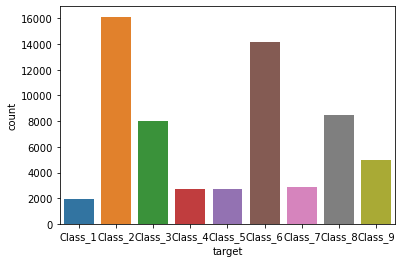

In [37]:
sns.countplot(df_train['target'])

The dataset is highly unbalanced, since some categories contains more products (e.g class 2) while others have very low numbers of products (e.g. class 1)

In [38]:
df_train['target'].unique()

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

#### Correlation matrix

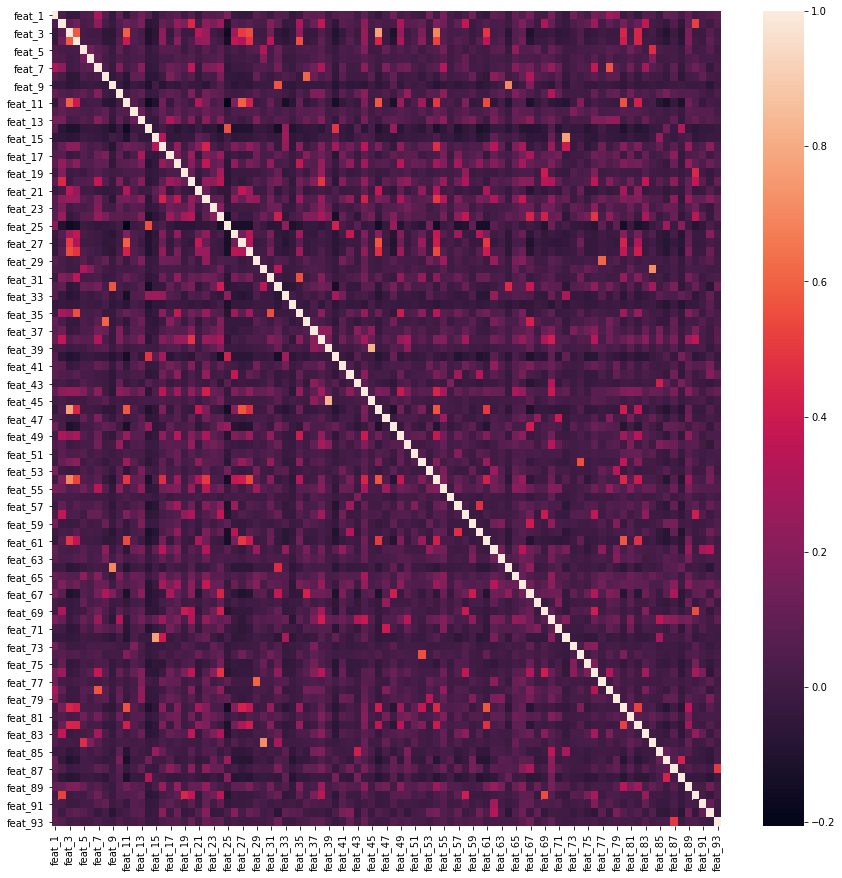

In [39]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr())

In [40]:
df_train['feat_1'].unique()

array([ 1,  0,  2,  3,  5,  8,  4,  7,  6, 25,  9, 23, 22, 15, 13, 12, 10,
       30, 28, 26, 11, 16, 29, 27, 21, 17, 14, 19, 31, 39, 42, 48, 61, 24,
       37, 32, 47, 20, 43, 40, 56, 34], dtype=int64)

#### Let's plot the distribution of a few features

(0.0, 10.0)

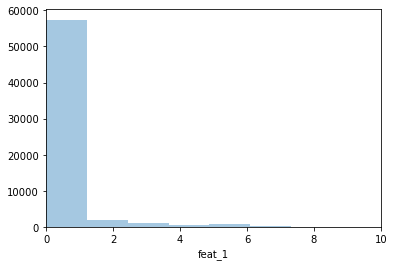

In [41]:
sns.distplot(df_train['feat_1'],kde=False)
plt.xlim(0,10)

(0.0, 10.0)

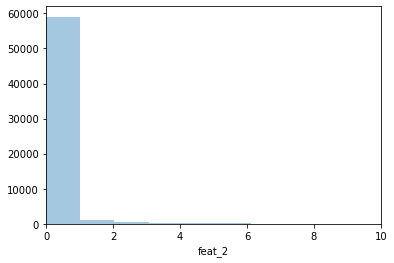

In [42]:
sns.distplot(df_train['feat_2'],kde=False)
plt.xlim(0,10)

It seems that the distribution of each feature has a peak at 0, and then some counts at 1, 2, etc. So the distributions are quite skewed.

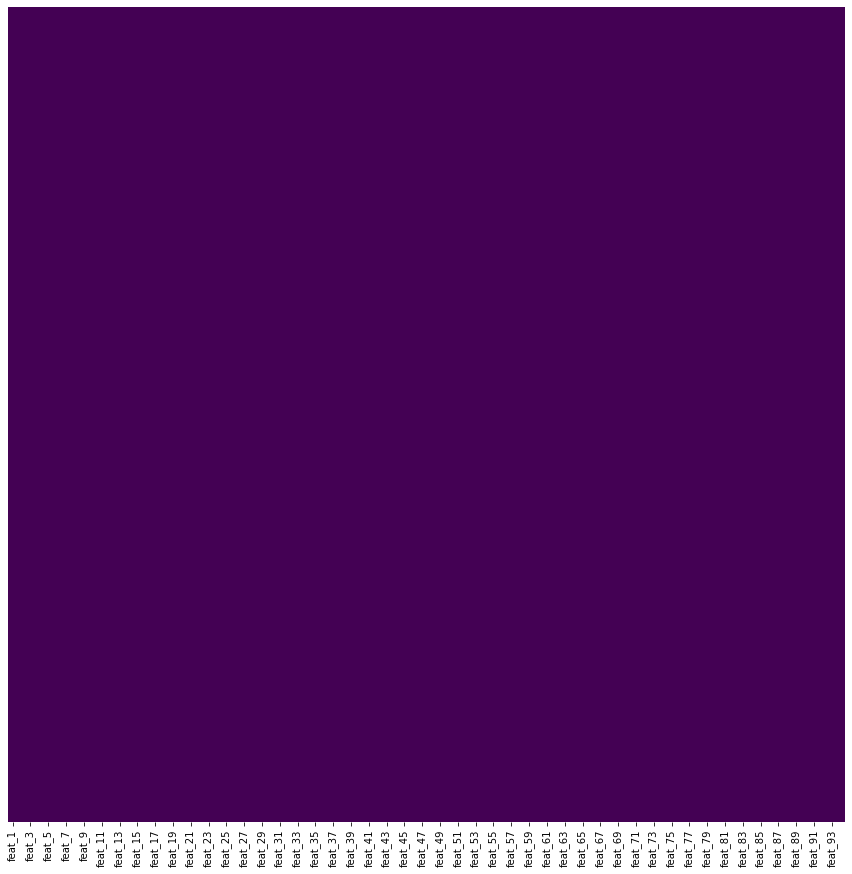

In [43]:
plt.figure(figsize=(15,15))
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

No missing data.

#### We add a new variable 'sum' which contains the sum of all other columns. It may be useful:

In [4]:
def count_feat(x):
    count = 0
    for i in range(1,94):
        count += x['feat_'+str(i)]
    return count

df_train['sum'] = df_train.apply(lambda row: count_feat(row), axis=1)

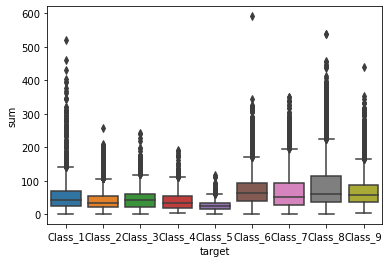

In [5]:
sns.boxplot(y='sum',data=df_train,x='target')

#### Now we apply a log transformation to our data (I've run the analysis with and without this step, and the log transformation helps in giving better results):

In [6]:
X = df_train.drop('target',axis=1)
y = df_train['target']

X = np.log(X.apply(lambda x: x+1)) #apply log transform log(x+1)

#### After the log transformation, the distribution of one variable looks like this:

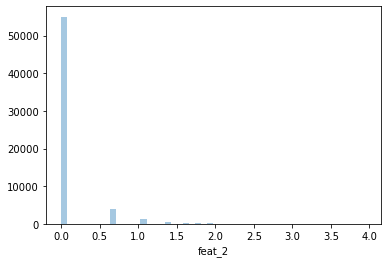

In [70]:
sns.distplot(X['feat_2'],kde=False)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

#### We also scale the dataset. This is needed for most methods we will use, although for some of them (e.g. trees methods) is not necessary

In [8]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.37840072, 0.        , 0.        , 0.        , 0.        ,
       0.19055141, 0.18316925, 0.19823986, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.19702696, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.23557985,
       0.        , 0.        , 0.        , 0.15863496, 0.37580365,
       0.        , 0.18544902, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.17718382, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.31992323, 0.        , 0.        , 0.18790182,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15773

As we have seen before, the dataset is highly unbalanced. It's better to re-balance the observations in the different classes before training our model.

However, let's evaluate the difference in performance: original dataset vs dataset after oversampling. We will do it by choosing one model (logistic regression) and training it before and after oversampling.

## Logistic regression using the original dataset (no oversampling)

In [50]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(multi_class='multinomial',solver='saga')
logmodel.fit(X_train,y_train)

predictions = logmodel.predict(X_test)

              precision    recall  f1-score   support

     Class_1       0.57      0.37      0.45       391
     Class_2       0.65      0.86      0.74      3236
     Class_3       0.53      0.33      0.41      1664
     Class_4       0.74      0.33      0.46       550
     Class_5       0.94      0.95      0.94       508
     Class_6       0.91      0.92      0.92      2747
     Class_7       0.66      0.54      0.59       556
     Class_8       0.85      0.88      0.87      1701
     Class_9       0.79      0.85      0.82      1023

    accuracy                           0.75     12376
   macro avg       0.74      0.67      0.69     12376
weighted avg       0.75      0.75      0.74     12376



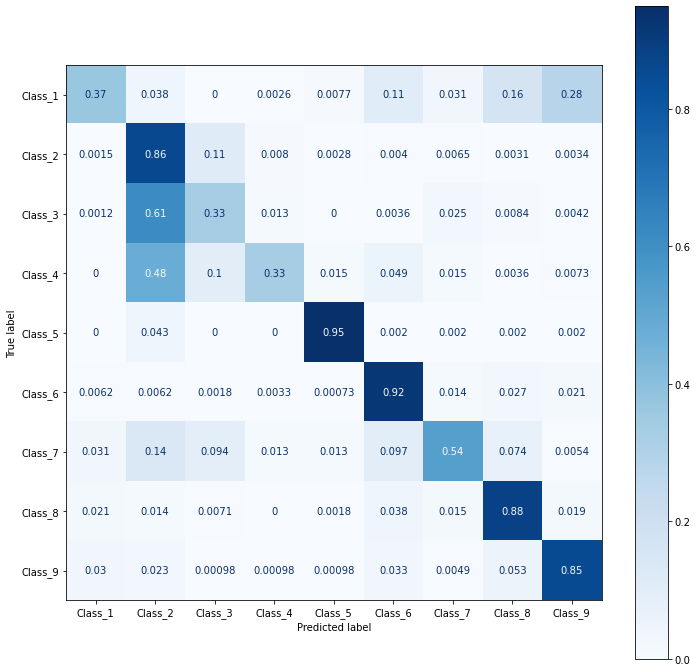

In [51]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(logmodel, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

#### We can see that while the recall on the most common classes (e.g. class 2) is good, the recall on the most rare classes is very bad (e.g.class 1,3,4) 

## Logistic regression after applying oversampling:

For oversampling, we will use the SMOTE method. SMOTE synthesizes new data points from the minority classes, by selecting points that are close in the feature space. Technically, it works by drawing a line between examples in the feature space and creating a new sample at a point along that line. 

In [52]:
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour
from collections import Counter
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print(f"before oversampling: {counter}")

#undersample = CondensedNearestNeighbour(n_neighbors=1)
#undersample = NearMiss(version=3, n_neighbors=2)
oversample = SMOTE(random_state=101)
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(f"after oversampling: {counter}")

before oversampling: Counter({'Class_2': 12886, 'Class_6': 11388, 'Class_8': 6763, 'Class_3': 6340, 'Class_9': 3932, 'Class_7': 2283, 'Class_5': 2231, 'Class_4': 2141, 'Class_1': 1538})
after oversampling: Counter({'Class_6': 12886, 'Class_3': 12886, 'Class_9': 12886, 'Class_5': 12886, 'Class_8': 12886, 'Class_1': 12886, 'Class_2': 12886, 'Class_4': 12886, 'Class_7': 12886})


In [53]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(multi_class='multinomial',solver='saga')
logmodel.fit(X_train,y_train)

predictions = logmodel.predict(X_test)

              precision    recall  f1-score   support

     Class_1       0.36      0.63      0.46       391
     Class_2       0.80      0.57      0.66      3236
     Class_3       0.49      0.53      0.51      1664
     Class_4       0.33      0.67      0.44       550
     Class_5       0.90      0.96      0.93       508
     Class_6       0.96      0.86      0.91      2747
     Class_7       0.47      0.69      0.56       556
     Class_8       0.88      0.82      0.85      1701
     Class_9       0.79      0.81      0.80      1023

    accuracy                           0.71     12376
   macro avg       0.66      0.73      0.68     12376
weighted avg       0.76      0.71      0.72     12376



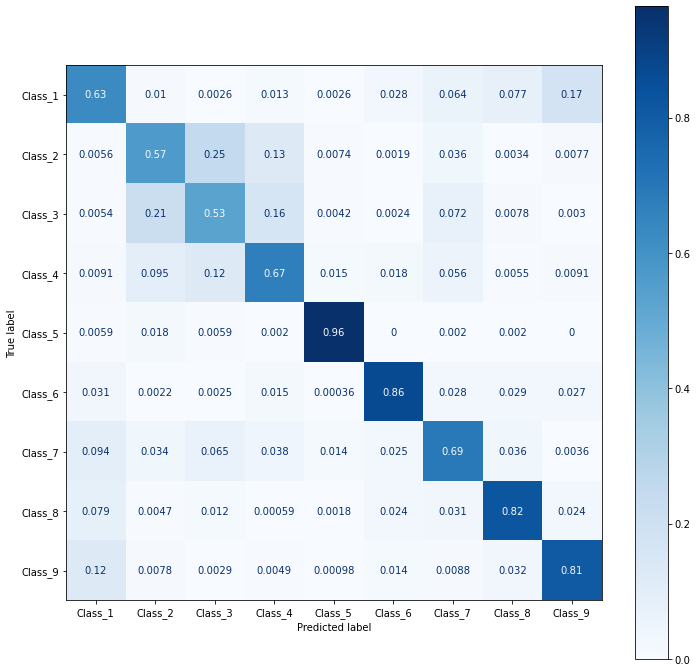

In [54]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(logmodel, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

Thanks to the oversampling, we managed to increase the recall on those classes that contain less observation (e.g. class 1,3,4). 

The overall accuracy on all classes is still 71% though, not very good. Let's check the performances of the other algorithms.

## k-nearest neighbors

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

predictions = knn.predict(X_test)

              precision    recall  f1-score   support

     Class_1       0.52      0.68      0.59       391
     Class_2       0.79      0.66      0.72      3236
     Class_3       0.53      0.62      0.57      1664
     Class_4       0.41      0.61      0.49       550
     Class_5       0.92      0.98      0.95       508
     Class_6       0.96      0.89      0.92      2747
     Class_7       0.60      0.69      0.64       556
     Class_8       0.93      0.89      0.91      1701
     Class_9       0.83      0.87      0.85      1023

    accuracy                           0.77     12376
   macro avg       0.72      0.76      0.74     12376
weighted avg       0.79      0.77      0.77     12376



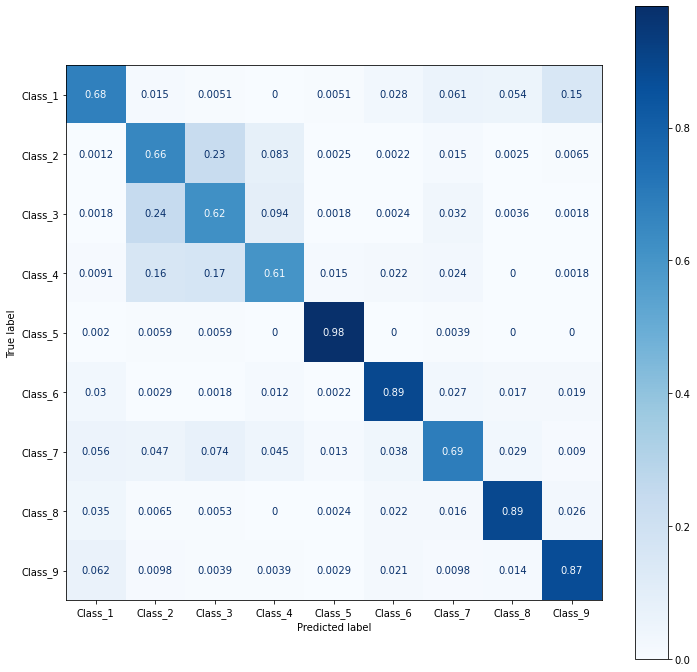

In [56]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(knn, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

Overall accuracy increased to 77%. We can try to further tune to n_neighbors parameter:

In [57]:
error_rate = []

# Will take some time
for i in range(1,20,3):
    
    print(f"Analzying: n = {i}")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Analzying: n = 1
Analzying: n = 4
Analzying: n = 7
Analzying: n = 10
Analzying: n = 13
Analzying: n = 16
Analzying: n = 19


Text(0, 0.5, 'Error Rate')

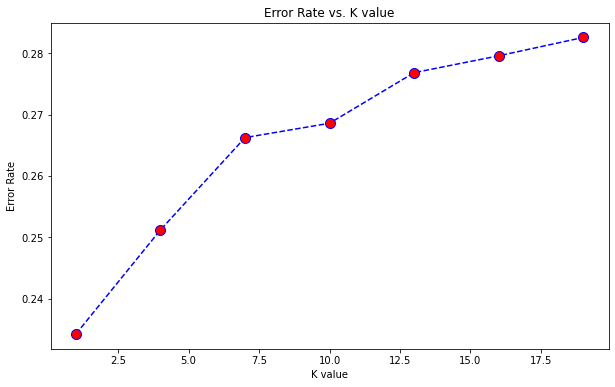

In [58]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20,3),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K value')
plt.xlabel('K value')
plt.ylabel('Error Rate')

It seems the error increases as we increase the value of k, so we cannot further improve using this model.

## Random forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)

              precision    recall  f1-score   support

     Class_1       0.73      0.55      0.63       391
     Class_2       0.74      0.84      0.79      3236
     Class_3       0.63      0.55      0.58      1664
     Class_4       0.78      0.52      0.62       550
     Class_5       0.96      0.98      0.97       508
     Class_6       0.95      0.94      0.94      2747
     Class_7       0.68      0.69      0.69       556
     Class_8       0.91      0.93      0.92      1701
     Class_9       0.85      0.88      0.86      1023

    accuracy                           0.81     12376
   macro avg       0.80      0.76      0.78     12376
weighted avg       0.81      0.81      0.81     12376



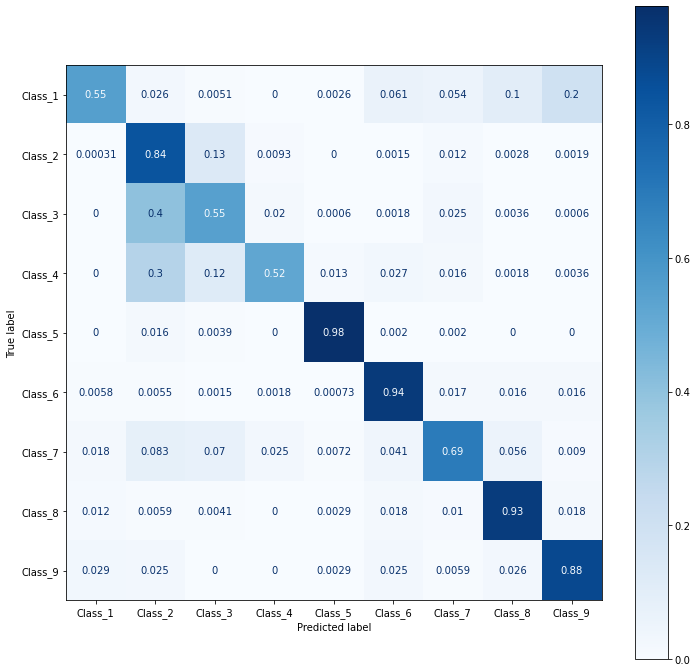

In [60]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(rfc, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

Overall, random forest seems to give better accuracy than previous models (81%), although the recall on class 3 and 4 is worse.

## Gradient boosted decision trees using XGBoost

In [61]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(eta=0.3,max_depth=5, verbosity=2)
xgb_model.fit(X_train,y_train)

predictions = xgb_model.predict(X_test)

              precision    recall  f1-score   support

     Class_1       0.61      0.57      0.59       391
     Class_2       0.74      0.81      0.77      3236
     Class_3       0.60      0.53      0.56      1664
     Class_4       0.70      0.54      0.61       550
     Class_5       0.96      0.97      0.96       508
     Class_6       0.95      0.93      0.94      2747
     Class_7       0.68      0.70      0.69       556
     Class_8       0.91      0.91      0.91      1701
     Class_9       0.85      0.88      0.86      1023

    accuracy                           0.80     12376
   macro avg       0.78      0.76      0.77     12376
weighted avg       0.80      0.80      0.80     12376



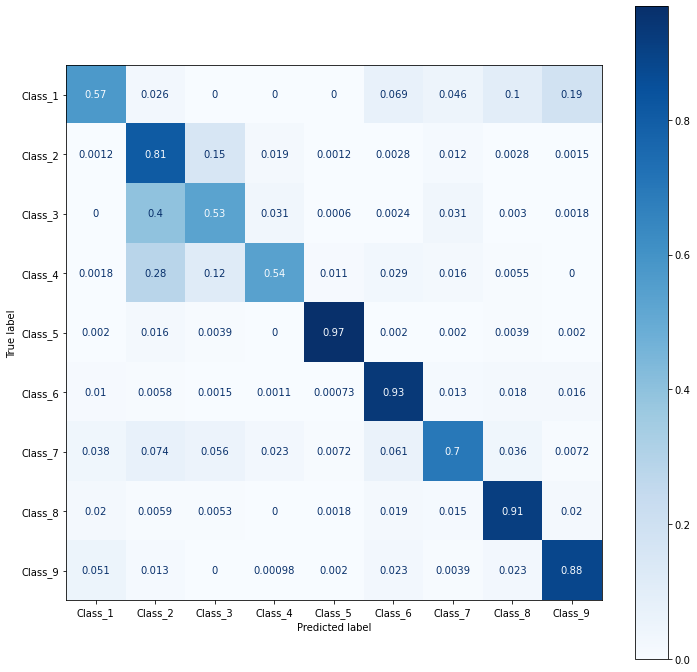

In [62]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(xgb_model, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

Performances are similar to random forest, but with much longer computational time.

## Principal component analysis

Since we have 93 features, we can use principal component analsyis to scale dimensions.

We try reducing to 2 dimensions only first:

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_train)

Text(0, 0.5, 'Second Principal Component')

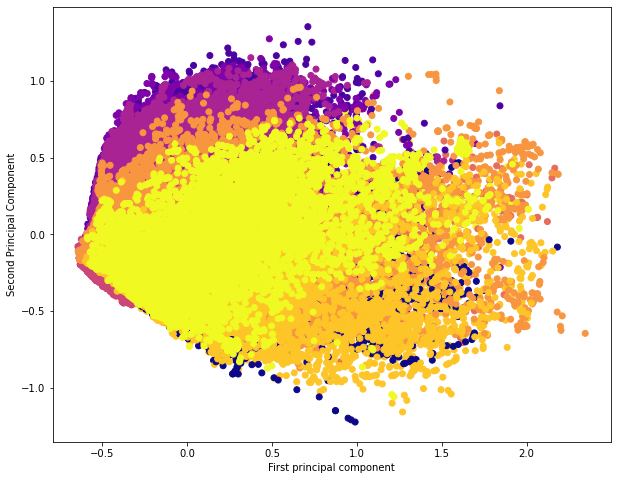

In [64]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
classes = le.transform(y_train)
#print(classes)

plt.figure(figsize=(10,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c=classes,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

If we reduce to 2 dimensions, it seems the 9 classes are not well separated. Probably more dimensions are needed.

#### Let's look at how much variance is explained when we choose a certain number of components:

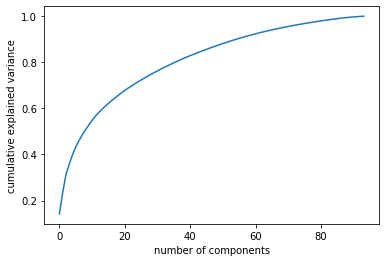

In [65]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

From the plot we see that n = 2 is definitely too low, since we can explain only 20% of the variance of the dataset.

#### In order to keep most of the variance in our data we should keep most of the features, such as n = 60. Therefore, we won't use PCA and we will just use all features.

## TSNE

This is another algorithm for dimensionality reduction: however, this is non-linear (while PCA is linear), so let's see if it gives better results.

In [73]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=101)
tsne = model.fit_transform(X_train)

Text(0, 0.5, 'tsne2')

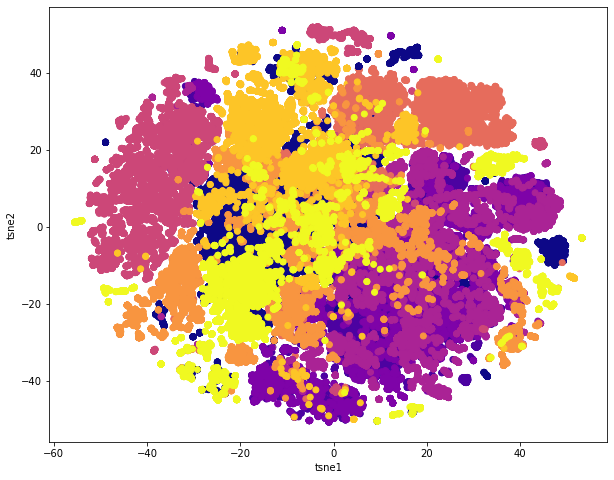

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(tsne.T[0],tsne.T[1],c=classes,cmap='plasma')
plt.xlabel('tsne1')
plt.ylabel('tsne2')

We can identify a few clusters associated to certain classes, however there is still no clear separation between the other categories. Probably need more dimensions.

#### We can try to apply TSNE on the full dataset. We will apply PCA first and the TSNE, and we will visualize the result in 3 dimensions:

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

df_sub = df_train

X = df_sub.drop('target',axis=1)
y = df_sub['target']

le = preprocessing.LabelEncoder()
le.fit(y)
classes = le.transform(y)

#we apply PCA first
pca = PCA(n_components=50, random_state=101)
x_pca = pca.fit_transform(X)

#Then we apply TSNE
model = TSNE(n_components=3, random_state=101)
tsne = model.fit_transform(x_pca)


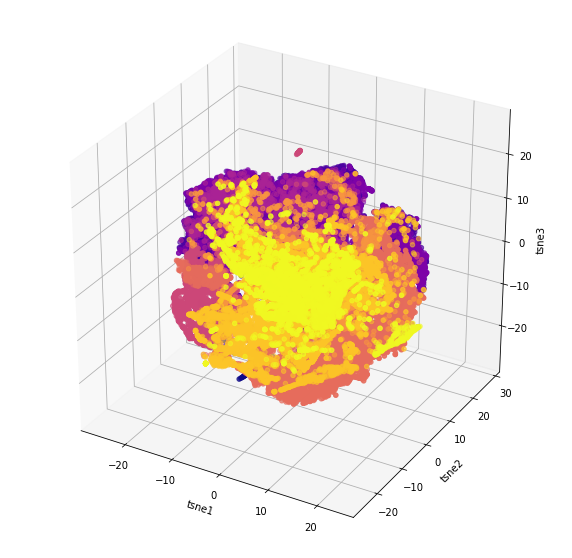

In [17]:
#For interactive version of the plot
#%matplotlib qt
%matplotlib inline

#We plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne.T[0],tsne.T[1],tsne.T[2],c=classes,cmap='plasma')

ax.set_xlabel('tsne1')
ax.set_ylabel('tsne2')
ax.set_zlabel('tsne3')

plt.show()

#### Even when looking at the interactive 3D-plot, the various classes don't seem well-separable.

## Stacking classifier

Here we will be using a stacking classifier combining different machine learning algorithms together, specifically:
* Random forest
* k-nearest neighbors
* Logistic regression

In [66]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('knn', KNeighborsClassifier(n_neighbors=1))
     ]

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(multi_class='multinomial',solver='saga')
)

clf.fit(X_train,y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier(n_neighbors=1))],
                   final_estimator=LogisticRegression(multi_class='multinomial',
                                                      solver='saga'))

In [67]:
predictions = clf.predict(X_test)

              precision    recall  f1-score   support

     Class_1       0.70      0.62      0.66       391
     Class_2       0.76      0.83      0.79      3236
     Class_3       0.61      0.56      0.59      1664
     Class_4       0.73      0.53      0.61       550
     Class_5       0.94      0.98      0.96       508
     Class_6       0.94      0.94      0.94      2747
     Class_7       0.68      0.68      0.68       556
     Class_8       0.93      0.91      0.92      1701
     Class_9       0.85      0.88      0.87      1023

    accuracy                           0.81     12376
   macro avg       0.79      0.77      0.78     12376
weighted avg       0.81      0.81      0.81     12376



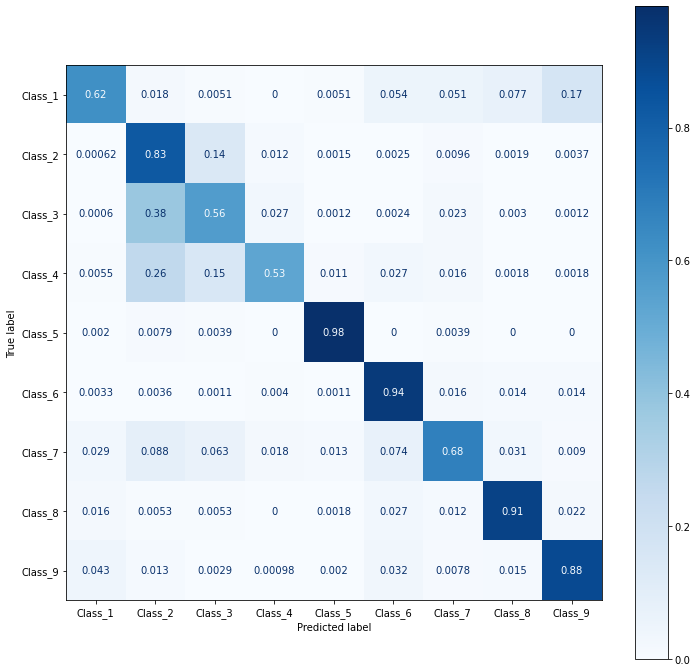

In [68]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

We can see a little improvement compared to random forest, however at a cost of longer computational time.

## Conclusions

In this notebook I have compared different algorithms on the Otto products dataset. In general, I've observed the following:
* Oversampling the dataset and applying a log transformation helps in the overall performances
* Random forest classifier and stacking of different algorithms give best performance

Overall accuracy for the different algorithms:
* Logistic regression: 71%
* K-nearest neighbors: 77%
* Random forest: 81%
* Gradient boosting decision trees: 80%
* Stacking: 81%

Dimensionality reduction techniques do not help much, given that many features are required in order to explain most of the variance in data.

Further improvements can be probably obtained using neural networks (the dataset is large enough to try this approach as well).